In [1]:
from datetime import datetime
import numpy as np
from itertools import izip
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [ ]:
# create and fit the LSTM network
def train_LSTM():

    # load the dataset
    dataset = np.asarray(y)
    dataset = dataset.reshape(-1,1)
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    batch_size = 1
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(200):
        print i
        model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()

        # make predictions
        trainPredict = model.predict(trainX, batch_size=batch_size)
        model.reset_states()
        testPredict = model.predict(testX, batch_size=batch_size)

        #print(trainPredict.shape)
        #print(testPredict.shape)

        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY_print = scaler.inverse_transform(trainY)
        testPredict = scaler.inverse_transform(testPredict)
        testY_print = scaler.inverse_transform(testY)
        trainScore = math.sqrt(mean_squared_error(trainY_print, trainPredict[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY_print, testPredict[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))

        plt.plot(testY_print)
        plt.plot(testPredict[:,0])
        plt.show()
        
    return model

    #model.load_weights(path, by_name=True)
    # model = load_model(path)
    #callbacks=[tensorboard, EpochEndCallback()]
    
    

(5965,)
(15291,)
(15291,)


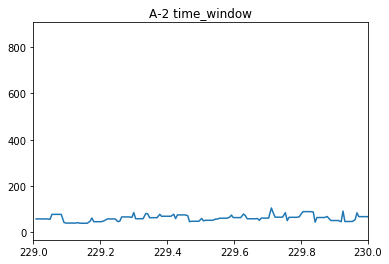

0
Epoch 1/1
101s - loss: 0.0012
Train Score: 27.89 RMSE
Test Score: 18.52 RMSE


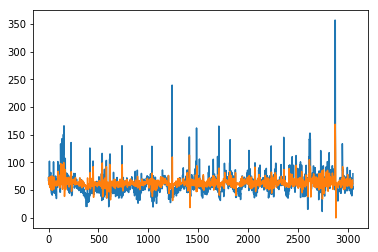

1
Epoch 1/1
96s - loss: 9.6110e-04
Train Score: 24.75 RMSE
Test Score: 16.30 RMSE


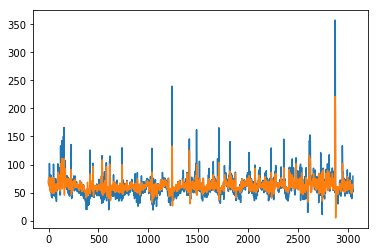

2
Epoch 1/1
103s - loss: 8.0219e-04
Train Score: 23.50 RMSE
Test Score: 15.42 RMSE


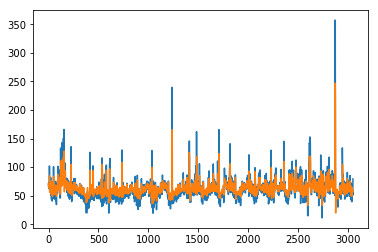

3
Epoch 1/1
101s - loss: 7.6905e-04
Train Score: 23.29 RMSE
Test Score: 15.27 RMSE


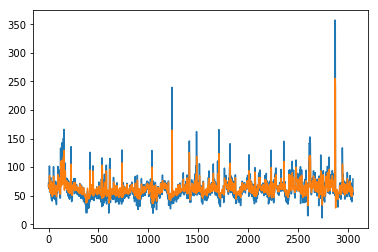

4
Epoch 1/1
98s - loss: 7.5811e-04
Train Score: 23.17 RMSE
Test Score: 15.21 RMSE


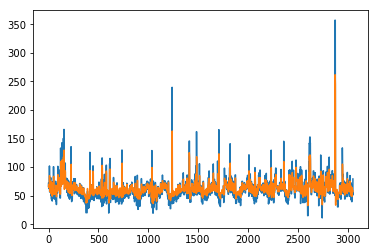

5
Epoch 1/1
93s - loss: 7.5102e-04
Train Score: 23.11 RMSE
Test Score: 15.19 RMSE


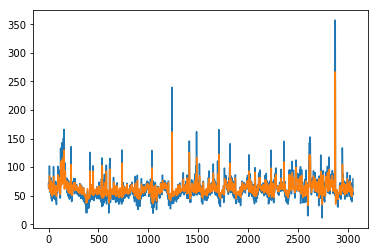

6
Epoch 1/1
106s - loss: 7.4627e-04
Train Score: 23.07 RMSE
Test Score: 15.18 RMSE


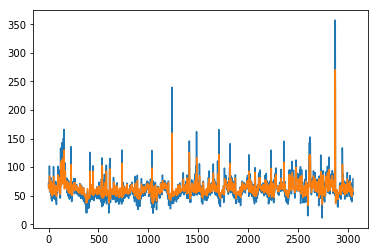

7
Epoch 1/1
98s - loss: 7.4304e-04
Train Score: 23.04 RMSE
Test Score: 15.17 RMSE


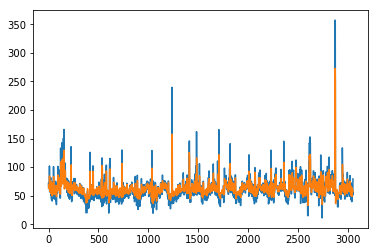

8
Epoch 1/1
108s - loss: 7.4086e-04
Train Score: 23.02 RMSE
Test Score: 15.18 RMSE


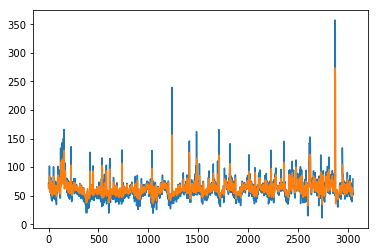

9
Epoch 1/1
102s - loss: 7.3933e-04
Train Score: 23.01 RMSE
Test Score: 15.18 RMSE


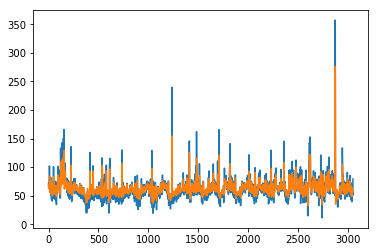

10
Epoch 1/1
111s - loss: 7.3868e-04
Train Score: 22.99 RMSE
Test Score: 15.20 RMSE


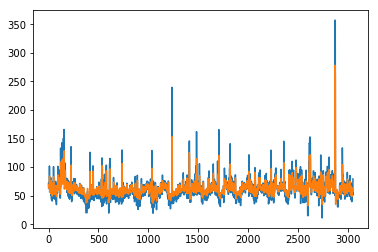

11
Epoch 1/1
116s - loss: 7.3830e-04
Train Score: 23.00 RMSE
Test Score: 15.20 RMSE


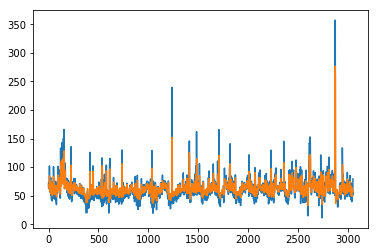

12
Epoch 1/1
118s - loss: 7.3865e-04
Train Score: 23.02 RMSE
Test Score: 15.19 RMSE


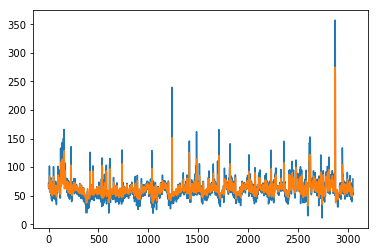

13
Epoch 1/1
116s - loss: 7.3916e-04
Train Score: 23.03 RMSE
Test Score: 15.17 RMSE


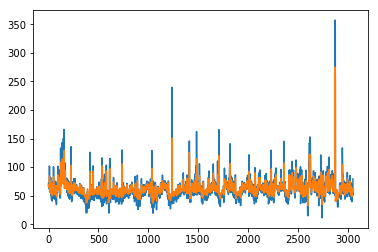

14
Epoch 1/1


In [ ]:
# Data preparations

volume = pd.read_csv('scripts/training_20min_avg_travel_time.csv', index_col=[0,1], header=0, engine='python')

routes = [('A',2),('A',3),('B',1),('B',3),('C',1),('C',3)]

# print(((volume.loc['B']).loc[3]))


for intersection, tollgate in routes:
    ax = plt.subplot(111)
    ax.set_xlim([229,230]) 
    plt.title(intersection + "-" + str(tollgate) + " " + volume.columns.values[0])
    
    windows = ((volume.loc[intersection]).loc[tollgate].values[:,0])
    periods = np.array(((volume.loc[intersection]).loc[tollgate]).values[:,1])
    
    periods.shape
    
    print periods.shape
    x = []
    y = []
    window0 = 0
    for window, period in izip(windows, periods):
        window = window.split(',')[0].replace('[', '')
        window = datetime.strptime(window, "%Y-%m-%d %H:%M:%S")
        window = window.month*30 + window.day + window.hour/24. + (window.minute+10)/3600.
        if window0 == 0:
            window0 = window
        for i in xrange( int((window - window0) * 180) - 1):
            x.append(x[-1]+1./180.)
            y.append(y[-1])
        else:
            x.append(window)
            y.append(period)
            window0 = window
            
    x = np.asarray(x)
    y = np.asarray(y)

    print x.shape
    print y.shape    
        
    plt.plot(x,y)
    plt.show()
    
    look_back = 3
    
    model = train_LSTM()
    model.save("models/" + str(intersection) + str(tollgate) + "_" + datetime.now().isoformat('_')  +'.h5')
    


model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

499
Epoch 1/1
41s - loss: 7.4041e-04
Train Score: 22.83 RMSE
Test Score: 15.15 RMSE

----------------------